In [1]:
include("../src/PhasorNetworks.jl")
using .PhasorNetworks, Plots, DifferentialEquations

[ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
┌ Warning: backend `GR` is not installed.
└ @ Plots ~/.julia/packages/Plots/ju9dp/src/backends.jl:43
[ Info: Precompiling IJuliaExt [2f4121a4-3b3a-5ce6-9c5e-1f2673ce168a]


In [2]:
using Lux, MLUtils, MLDatasets, OneHotArrays, Statistics, Test
using Random: Xoshiro, AbstractRNG
using Base: @kwdef
using Zygote: withgradient
using LuxDeviceUtils: cpu_device, gpu_device
using Optimisers, ComponentArrays
using Statistics: mean
using LinearAlgebra: diag
using PhasorNetworks: bind
using Distributions: Normal
using DifferentialEquations: Heun, Tsit5

[ Info: Precompiling FileIOExt [f5f51d8f-5827-5d2e-939b-192fcd6ec70c]


In [3]:
solver_args = Dict(:adaptive => false, :dt => 0.01)

Dict{Symbol, Real} with 2 entries:
  :adaptive => false
  :dt       => 0.01

In [4]:
spk_args = SpikingArgs(threshold = 0.001,
                    solver=Tsit5(), 
                    solver_args = solver_args)

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)


In [5]:
#global args for all tests
n_x = 101
n_y = 101
n_vsa = 1
epsilon = 0.10
repeats = 10
epsilon = 0.025


tspan = (0.0, repeats*1.0)
tbase = collect(tspan[1]:spk_args.solver_args[:dt]:tspan[2])

@kwdef mutable struct Args
    η::Float64 = 3e-4       ## learning rate
    batchsize::Int = 256    ## batch size
    epochs::Int = 10        ## number of epochs
    use_cuda::Bool = false   ## use gpu (if cuda available)
    rng::Xoshiro = Xoshiro(42) ## global rng
end

Args

In [6]:
include("../test/network_tests.jl")

spiking_accuracy_test (generic function with 1 method)

In [7]:
import .PhasorNetworks: v_bundle_project, neuron_constant, spike_current, bias_current, gaussian_kernel, is_active

In [8]:
args = Args()

Args(0.0003, 256, 10, false, Xoshiro(0xa379de7eeeb2a4e8, 0x953dccb6b532b3af, 0xf597b8ff8cfd652a, 0xccd7337c571680d1, 0xc90c4a0730db3f7e))

In [9]:
train_loader, test_loader = getdata(args)
x, y = first(train_loader)

([0.4363590795046628 -0.020726939563912576 … -0.014802110970796872 -0.0019893102515646105; -0.17784306532747968 0.3038012525038328 … -0.07276908176492998 -0.005627426425963785], Bool[0 0 … 1 1; 1 1 … 0 0])

# Test FP32

In [10]:
function build_mlp_f32(args)
    phasor_model = Chain(LayerNorm((2,)), x -> tanh_fast.(x), x -> x, PhasorDenseF32(2 => 128), PhasorDenseF32(128 => 2))
    ps, st = Lux.setup(args.rng, phasor_model)
    return phasor_model, ps, st
end

function build_spiking_mlp_f32(args, spk_args)
    spk_model = Chain(LayerNorm((2,)), x -> tanh_fast.(x), MakeSpiking(spk_args, repeats), PhasorDenseF32(2 => 128), PhasorDenseF32(128 => 2))
    ps, st = Lux.setup(args.rng, spk_model)
    return spk_model, ps, st
end

build_spiking_mlp_f32 (generic function with 1 method)

In [11]:
model_f, ps_f, st_f = build_mlp_f32(args)

(Chain{@NamedTuple{layer_1::LayerNorm{true, 1, typeof(identity), Float32, typeof(zeros32), typeof(ones32), Colon}, layer_2::WrappedFunction{:direct_call, var"#35#37"}, layer_3::WrappedFunction{:direct_call, var"#36#38"}, layer_4::PhasorDenseF32, layer_5::PhasorDenseF32}, Nothing}((layer_1 = LayerNorm((2,), affine=true, dims=Colon()), layer_2 = WrappedFunction{:direct_call}(var"#35#37"()), layer_3 = WrappedFunction{:direct_call}(var"#36#38"()), layer_4 = PhasorDenseF32((2, 128)), layer_5 = PhasorDenseF32((128, 2))), nothing), (layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[0.025199654 0.005086061; 0.021546587 -0.11127125; … ; 0.15865159 -0.030458387; -0.24032864 0.049523916], bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0

In [12]:
spk_model_f, _, _ = build_spiking_mlp_f32(args, spk_args)

(Chain{@NamedTuple{layer_1::LayerNorm{true, 1, typeof(identity), Float32, typeof(zeros32), typeof(ones32), Colon}, layer_2::WrappedFunction{:direct_call, var"#39#40"}, layer_3::MakeSpiking, layer_4::PhasorDenseF32, layer_5::PhasorDenseF32}, Nothing}((layer_1 = LayerNorm((2,), affine=true, dims=Colon()), layer_2 = WrappedFunction{:direct_call}(var"#39#40"()), layer_3 = MakeSpiking(Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, 10, (0.0, 10.0), 0.0), layer_4 = PhasorDenseF32((2, 128)), layer_5 = PhasorDenseF32((128, 2))), nothing), (layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[0.27116936 0.0861502; -0.07204794 -0.15312071; … ; -0.039547402 -0.030699156; 0.003936669 -0.020530548], bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 

In [13]:
y_f, _ = model_f(x, ps_f, st_f)

([-0.020149648238458575 0.045700038069459076 … 0.014530519942781352 0.011981539154404282; -0.02249536798937414 -0.009955395182095284 … -0.05483856973419426 -0.02312620330193895], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple()))

In [14]:
y_spk_f, _ = spk_model_f(x, ps_f, st_f)

(SpikingCall(Spike Train: (2, 256) with 5120 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0, 10.0)), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple()))

In [15]:
y_spk_f.train.offset

0.5

In [16]:
p_spk_f = train_to_phase(y_spk_f);

In [17]:
size(p_spk_f)

(10, 2, 256)

In [18]:
size(y_f)

(2, 256)

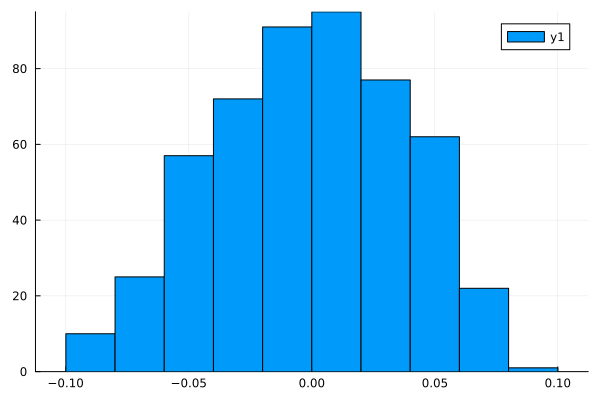

In [19]:
histogram(vec(p_spk_f[5,:,:]))

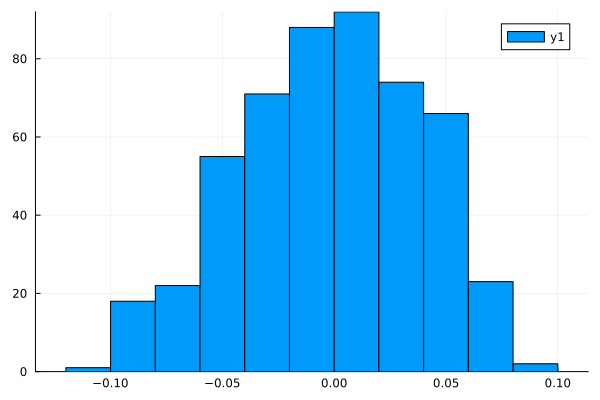

In [20]:
histogram(vec(p_spk_f[6,:,:]))

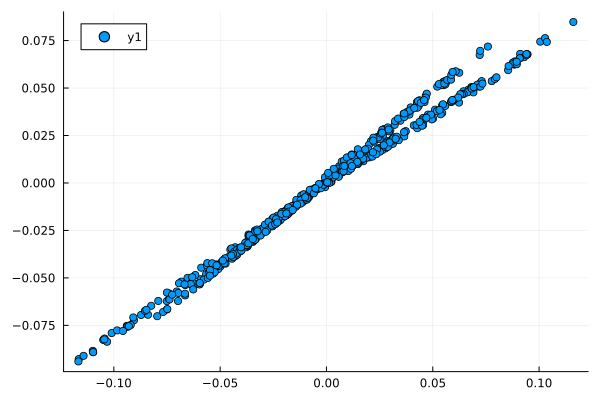

In [21]:
scatter(vec(y_f), vec(p_spk_f[5,:,:]))

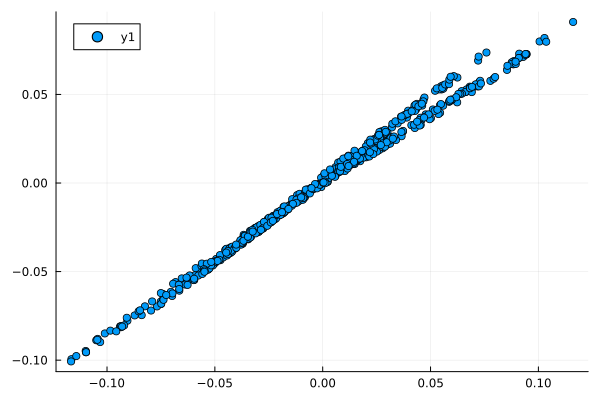

In [22]:
scatter(vec(y_f), vec(p_spk_f[6,:,:]))

In [23]:
cycle_correlation(y_f, p_spk_f)

10-element Vector{Float64}:
 NaN
   0.9574926579298872
   0.9827655855814497
   0.9911053910869371
   0.9945393684396691
   0.99615711825983
   0.9969892057674223
   0.9974437387193503
   0.9977028275031655
   0.987874664769192

In [24]:
losses_f, ps_train_f, st_train_f = train(model_f, ps_f, st_f, train_loader, args)

[ Info: Training on CPU


(Any[0.49872121134692143, 0.5211221973435561, 0.5082742474195519, 0.5136231831737799, 0.4943845354082511, 0.49740236463324033, 0.4872463266986948, 0.481221219549921, 0.48914629204794935, 0.4815789206296046  …  0.0568530273633278, 0.04347768528300689, 0.045888754199539736, 0.04510184537587257, 0.061042395060813236, 0.049483366029535035, 0.054607927545205576, 0.05410345407506266, 0.06503692399941924, 0.05217629091596032], (layer_1 = (bias = Float32[-0.19684447; -0.19686742;;], scale = Float32[0.81389666; 0.8042378;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[0.04173581 0.011097611; 0.007310995 -0.098167986; … ; 0.15090613 -0.018089933; -0.24436979 0.022904145], bias_real = Float32[0.9893609, 1.0206473, 1.0272624, 0.9854006, 0.8565414, 0.9733166, 0.9726222, 0.98102, 0.9935856, 0.97464263  …  0.9867618, 1.0006989, 1.0331075, 1.020813, 0.98554134, 1.0059948, 0.9812722, 0.9916397, 1.0107608, 0.9958822], bias_imag = Float32[-0.0050614476, -0.0040287124, 0.0

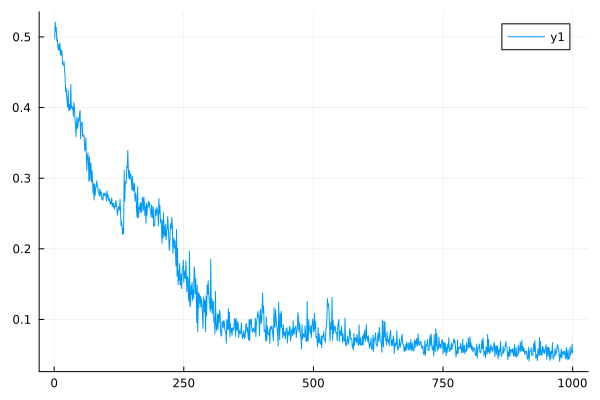

In [25]:
plot(losses_f)

In [26]:
loss_and_accuracy(test_loader, model_f, ps_train_f, st_train_f)

(0.05066728205196651, 0.973828125)

In [27]:
ps_train_f.layer_1

(bias = Float32[-0.19684447; -0.19686742;;], scale = Float32[0.81389666; 0.8042378;;])

In [28]:
yt_f, _ = model_f(x, ps_train_f, st_train_f)

([-0.06431134566450077 0.10651670865384275 … 0.5060976718095738 0.5578967142335515; 0.39281427269815455 0.4373721880071353 … 0.11791260437980783 0.024660960856190333], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple()))

In [29]:
ps_train_f

(layer_1 = (bias = Float32[-0.19684447; -0.19686742;;], scale = Float32[0.81389666; 0.8042378;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[0.04173581 0.011097611; 0.007310995 -0.098167986; … ; 0.15090613 -0.018089933; -0.24436979 0.022904145], bias_real = Float32[0.9893609, 1.0206473, 1.0272624, 0.9854006, 0.8565414, 0.9733166, 0.9726222, 0.98102, 0.9935856, 0.97464263  …  0.9867618, 1.0006989, 1.0331075, 1.020813, 0.98554134, 1.0059948, 0.9812722, 0.9916397, 1.0107608, 0.9958822], bias_imag = Float32[-0.0050614476, -0.0040287124, 0.0074766246, -0.014946235, 0.109835275, 0.0017270701, -0.027147572, 0.056947954, -0.00028140467, -0.010189336  …  -0.03223262, -0.036699872, -0.0041815965, 0.00930367, -0.00264803, 0.0015649532, -0.01621104, 0.02037809, 0.016045837, -0.02900312]), layer_5 = (weight = Float32[0.12459448 -0.12286748 … -0.122526824 -0.13777; -0.055697106 -0.06724836 … -0.027451849 0.09509349], bias_real = Float32[0.99746597, 0.9874371], bias_

In [30]:
yt_spk_f, _ = spk_model_f(x, ps_train_f, st_train_f)

(SpikingCall(Spike Train: (2, 256) with 5120 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0, 10.0)), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple()))

In [31]:
pt_f = train_to_phase(yt_spk_f.train, spk_args=spk_args);

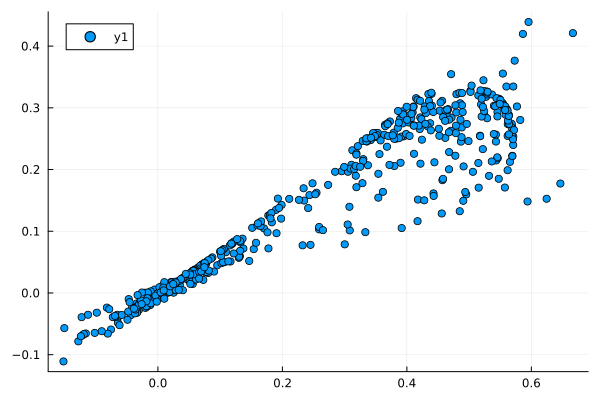

In [32]:
scatter(vec(yt_f), vec(pt_f[end-1,:,:]))

In [33]:
cycle_correlation(yt_f, pt_f)

10-element Vector{Float64}:
 0.006461719595410191
 0.7612329428711189
 0.7876563240679477
 0.8183012011102203
 0.8496381593542799
 0.8793015402733626
 0.9056243865568043
 0.9278058184415781
 0.9457683686352797
 0.6378516516150825

In [43]:
import LuxLib: dropout

In [37]:
seed = Xoshiro(42)

Xoshiro(0xa379de7eeeb2a4e8, 0x953dccb6b532b3af, 0xf597b8ff8cfd652a, 0xccd7337c571680d1, 0xc90c4a0730db3f7e)

In [40]:
rand(seed, Float32, (4))

4-element Vector{Float32}:
 0.2763728
 0.7219827
 0.75006443
 0.37234658

In [53]:
function dropout(rng::AbstractRNG, x::SpikingCall, p::T, training, invp::T, dims) where {T}

    train = x.train
    n_s = length(train.indices)
    keep_inds = rand(rng, Float32, (n_s)) .>= p
    new_inds = train.indices[keep_inds]
    new_tms = train.times[keep_inds]
    new_train = SpikeTrain(new_inds, new_tms, train.shape, train.offset)
    new_call = SpikingCall(new_train, x.spk_args, x.t_span)
    return new_call
end

dropout (generic function with 7 methods)

In [60]:
yt_spk_f.train.indices |> size

(5120,)

In [54]:
dropout(seed, yt_spk_f, 0.2, true, 0.8, nothing)

SpikingCall(Spike Train: (2, 256) with 4110 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0, 10.0))

In [61]:
4110 / 5120

0.802734375

In [36]:
dropout(yt_f)

LoadError: MethodError: no method matching dropout(::Matrix{Float64})

[0mClosest candidates are:
[0m  dropout([91m::AbstractRNG[39m, [91m::AbstractArray{T1, N}[39m, [91m::AbstractArray{T2, N}[39m, [91m::T[39m, [91m::Val[39m, [91m::Val[39m; dims, invp) where {T, T1, T2, N}
[0m[90m   @[39m [35mLuxLib[39m [90m[4mdeprecated.jl:103[24m[39m
[0m  dropout([91m::AbstractRNG[39m, [91m::AbstractArray{T1, N}[39m, [91m::AbstractArray{T2, N}[39m, [91m::T[39m, [91m::Val[39m, [91m::Val[39m, [91m::T[39m; dims) where {T, T1, T2, N}
[0m[90m   @[39m [35mLuxLib[39m [90m[4mdeprecated.jl:103[24m[39m
[0m  dropout([91m::AbstractRNG[39m, [91m::AbstractArray[39m, [91m::AbstractArray[39m, [91m::T[39m, [91m::Static.StaticBool[39m, [91m::Static.True[39m, [91m::T[39m, [91m::Any[39m) where T
[0m[90m   @[39m [35mLuxLib[39m [90m~/.julia/packages/LuxLib/vG8lL/src/api/[39m[90m[4mdropout.jl:50[24m[39m
[0m  ...


# Test FP64

In [89]:
function convert_params(ps)
    ps2 = (layer_1 = ps.layer_1,
            layer_2 = ps.layer_2,
            layer_3 = ps.layer_3,
            layer_4 = (weight = ps.layer_4.weight, bias = ps.layer_4.bias_real .+ 1im .* ps.layer_4.bias_imag),
            layer_5 = (weight = ps.layer_5.weight, bias = ps.layer_5.bias_real .+ 1im .* ps.layer_5.bias_imag))
    return ps2
end

convert_params (generic function with 1 method)

In [90]:
function build_mlp(args)
    phasor_model = Chain(LayerNorm((2,)), x -> tanh_fast.(x), x -> x, PhasorDense(2 => 128), PhasorDense(128 => 2))
    ps, st = Lux.setup(args.rng, phasor_model)
    return phasor_model, ps, st
end

function build_spiking_mlp(args, spk_args)
    spk_model = Chain(LayerNorm((2,)), x -> tanh_fast.(x), MakeSpiking(spk_args, repeats), PhasorDense(2 => 128), PhasorDense(128 => 2))
    ps, st = Lux.setup(args.rng, spk_model)
    return spk_model, ps, st
end

build_spiking_mlp (generic function with 1 method)

In [91]:
model, ps0, st = build_mlp(args)

(Chain{@NamedTuple{layer_1::LayerNorm{true, 1, typeof(identity), Float32, typeof(zeros32), typeof(ones32), Colon}, layer_2::WrappedFunction{:direct_call, var"#53#55"}, layer_3::WrappedFunction{:direct_call, var"#54#56"}, layer_4::PhasorDense, layer_5::PhasorDense}, Nothing}((layer_1 = LayerNorm((2,), affine=true, dims=Colon()), layer_2 = WrappedFunction{:direct_call}(var"#53#55"()), layer_3 = WrappedFunction{:direct_call}(var"#54#56"()), layer_4 = PhasorDense((2, 128)), layer_5 = PhasorDense((128, 2))), nothing), (layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[-0.010895338 -0.24877726; -0.13634758 0.16116057; … ; 0.12740536 0.071945764; 0.07237525 0.14154586], bias = ComplexF32[1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im  …  1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 

In [92]:
ps = convert_params(ps_f)

(layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[0.025199654 0.005086061; 0.021546587 -0.11127125; … ; 0.15865159 -0.030458387; -0.24032864 0.049523916], bias = ComplexF32[1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im  …  1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im]), layer_5 = (weight = Float32[0.12666641 -0.120561965 … -0.12208452 -0.13078421; -0.04557358 -0.05778698 … -0.0043423125 0.09756272], bias = ComplexF32[1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im]))

In [93]:
spk_model, _, _ = build_spiking_mlp(args, spk_args)

(Chain{@NamedTuple{layer_1::LayerNorm{true, 1, typeof(identity), Float32, typeof(zeros32), typeof(ones32), Colon}, layer_2::WrappedFunction{:direct_call, var"#57#58"}, layer_3::MakeSpiking, layer_4::PhasorDense, layer_5::PhasorDense}, Nothing}((layer_1 = LayerNorm((2,), affine=true, dims=Colon()), layer_2 = WrappedFunction{:direct_call}(var"#57#58"()), layer_3 = MakeSpiking(Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, 10, (0.0, 10.0), 0.0), layer_4 = PhasorDense((2, 128)), layer_5 = PhasorDense((128, 2))), nothing), (layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[-0.024193441 0.034919705; 0.10638956 0.04141463; … ; -0.012476771 -0.016412683; 0.049349435 0.32208106], bias = ComplexF32[1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.

In [94]:
ps_f.layer_5.bias_real .+ 1im .* ps_f.layer_5.bias_imag

2-element Vector{ComplexF32}:
 1.0f0 + 0.0f0im
 1.0f0 + 0.0f0im

In [95]:
ps.layer_5.bias

2-element Vector{ComplexF32}:
 1.0f0 + 0.0f0im
 1.0f0 + 0.0f0im

In [96]:
y, _ = model(x, ps0, st)

([0.03741752040930414 -0.01154654911161082 … 0.04680916377925383 0.016532480362602856; 0.03526500248756764 0.0016749191968001853 … 0.042378212521375434 0.0143696300876539], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple()))

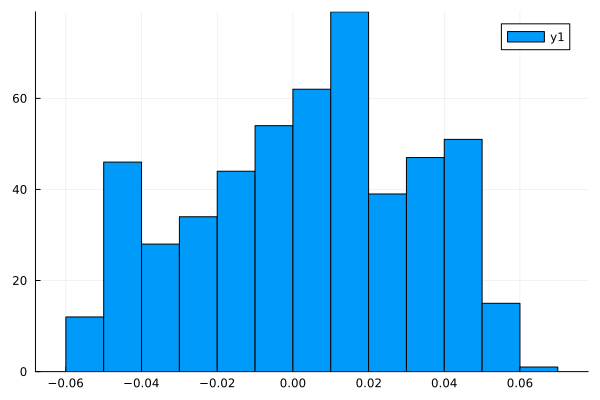

In [97]:
histogram(vec(y))

In [98]:
y_spk, _ = spk_model(x, ps0, st)

(SpikingCall(Spike Train: (2, 256) with 5120 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0, 10.0)), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple()))

In [99]:
y_spk.train.offset

0.5

In [100]:
p_spk = train_to_phase(y_spk);

In [101]:
size(p_spk)

(10, 2, 256)

In [102]:
size(y)

(2, 256)

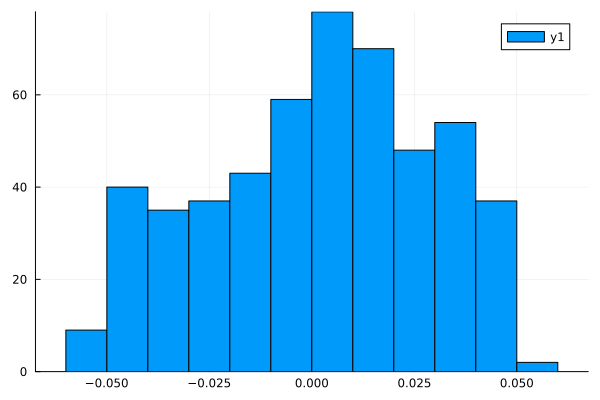

In [103]:
histogram(vec(p_spk[5,:,:]))

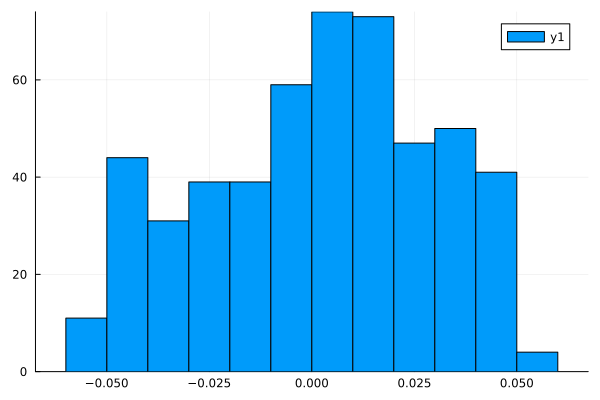

In [104]:
histogram(vec(p_spk[6,:,:]))

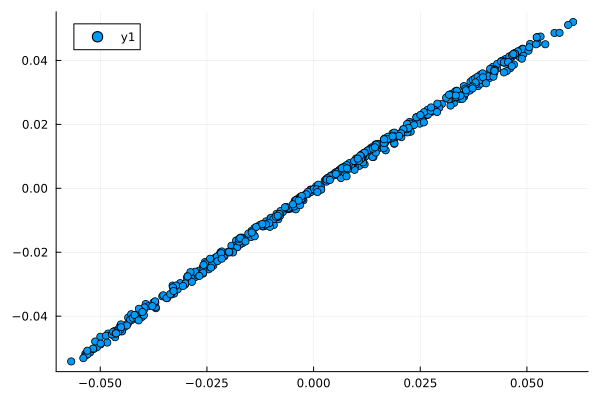

In [105]:
scatter(vec(y), vec(p_spk[5,:,:]))

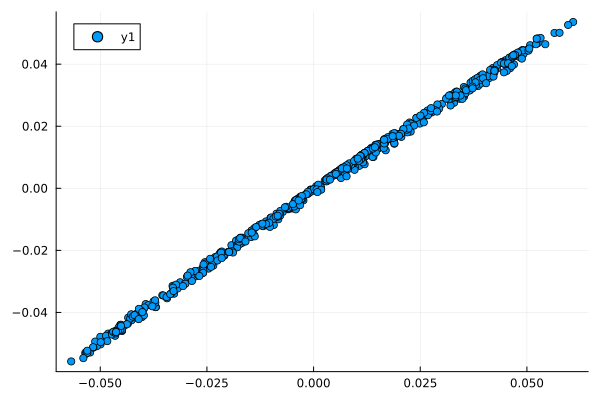

In [106]:
scatter(vec(y), vec(p_spk[6,:,:]))

In [107]:
y |> size

(2, 256)

In [108]:
p_spk |> size

(10, 2, 256)

In [109]:
cycle_correlation(y, p_spk)

10-element Vector{Float64}:
 NaN
   0.9967026846227459
   0.9984429535073293
   0.9988824690193129
   0.9990388000096878
   0.9991047016605774
   0.9991351632478318
   0.9991499059413155
   0.9991571041601189
   0.9839238676869153

In [110]:
losses, ps_train, st_train = train(model, ps0, st, train_loader, args)

[ Info: Training on CPU


(Any[0.49649153113511235, 0.5100650282824819, 0.5037751353238953, 0.5017866952583997, 0.5008823363308471, 0.49887407948225526, 0.4948599742692325, 0.485265587682978, 0.4972896490236325, 0.4860708098527353  …  0.056473500716210115, 0.04500828439034159, 0.043587750724415175, 0.042926763368772144, 0.06202322505287953, 0.05049558264475855, 0.05603819224965889, 0.05352237788174003, 0.06507306660048816, 0.05024413519364921], (layer_1 = (bias = Float32[-0.20942736; -0.14604901;;], scale = Float32[0.70277375; 0.8785927;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[-0.017019194 -0.24213392; -0.1303419 0.17105345; … ; 0.13702722 0.07441861; 0.07200687 0.12977605], bias = ComplexF32[1.0007441f0 - 0.009706826f0im, 1.0007925f0 - 0.022060279f0im, 0.9997956f0 - 0.016327888f0im, 1.0003569f0 - 0.010886992f0im, 1.0004566f0 + 0.025189083f0im, 1.0002024f0 - 0.012611652f0im, 0.9948956f0 - 0.013308102f0im, 0.9994935f0 + 0.027484942f0im, 0.9986262f0 - 0.0212648f0im, 1.00228

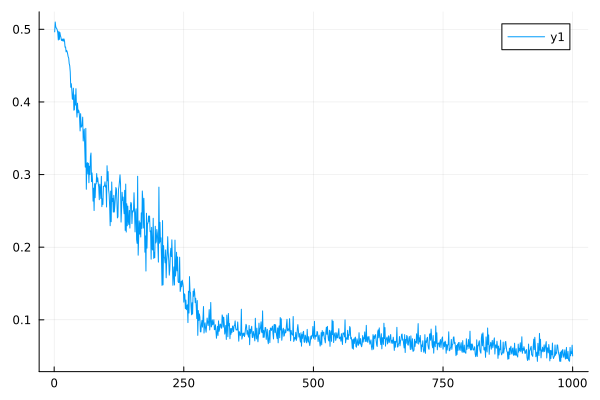

In [111]:
plot(losses)

In [112]:
loss_and_accuracy(test_loader, model, ps_train, st_train)

(0.05269125836338049, 0.978515625)

In [113]:
yt, _ = model(x, ps_train, st_train)

([-0.059364020198497146 0.1289278516849438 … 0.5098665887544654 0.5636289380767506; 0.4012695131386937 0.3979841914718843 … 0.13508030924012546 0.02403423923430901], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple()))

In [114]:
ps_train

(layer_1 = (bias = Float32[-0.20942736; -0.14604901;;], scale = Float32[0.70277375; 0.8785927;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[-0.017019194 -0.24213392; -0.1303419 0.17105345; … ; 0.13702722 0.07441861; 0.07200687 0.12977605], bias = ComplexF32[1.0007441f0 - 0.009706826f0im, 1.0007925f0 - 0.022060279f0im, 0.9997956f0 - 0.016327888f0im, 1.0003569f0 - 0.010886992f0im, 1.0004566f0 + 0.025189083f0im, 1.0002024f0 - 0.012611652f0im, 0.9948956f0 - 0.013308102f0im, 0.9994935f0 + 0.027484942f0im, 0.9986262f0 - 0.0212648f0im, 1.0022855f0 + 0.03200865f0im  …  1.0043336f0 - 0.004376335f0im, 0.99874973f0 + 0.021231128f0im, 0.99950826f0 + 0.028343882f0im, 1.0002247f0 - 0.007194185f0im, 1.0009332f0 + 0.011410159f0im, 0.993148f0 + 0.085884824f0im, 1.0001357f0 - 0.0062890523f0im, 0.90973747f0 + 0.2349537f0im, 0.9981709f0 - 0.044215016f0im, 1.0005319f0 - 0.030532412f0im]), layer_5 = (weight = Float32[0.041896474 0.06558912 … 0.033050828 0.0025507812; 0.050

In [115]:
yt_spk, _ = spk_model(x, ps_train, st_train)

(SpikingCall(Spike Train: (2, 256) with 5120 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0, 10.0)), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple()))

In [116]:
pt = train_to_phase(yt_spk.train, spk_args=spk_args);

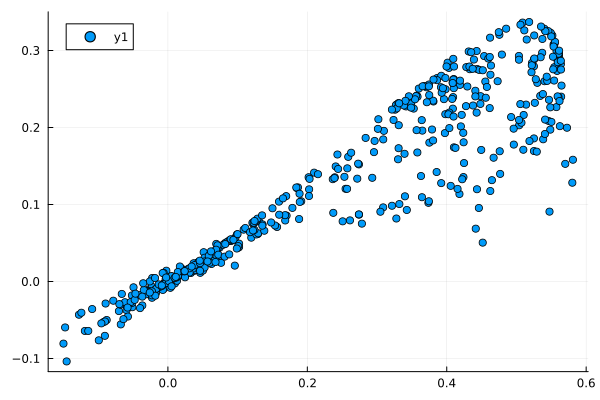

In [117]:
scatter(vec(yt), vec(pt[8,:,:]))

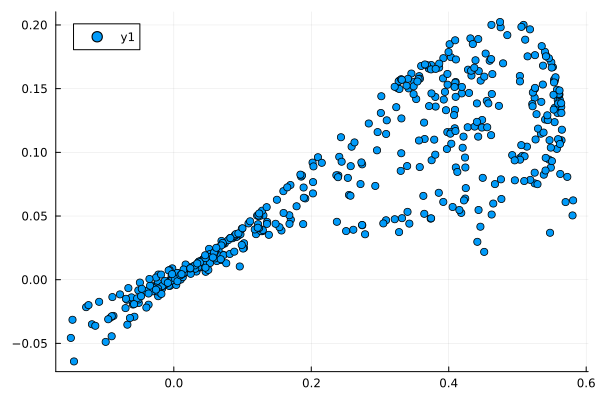

In [118]:
scatter(vec(yt), vec(pt[5,:,:]))

In [119]:
cycle_correlation(yt, pt)

10-element Vector{Float64}:
 0.0506378453785209
 0.7957932510906365
 0.8183247221962029
 0.8438405132893896
 0.869665750275526
 0.8941323728358883
 0.91611249041527
 0.9350181812291406
 0.9506982708762736
 0.8666421440644932

In [120]:
to_phase = Chain(LayerNorm((2,)), x -> tanh_fast.(x))
ps_phase, st_phase = Lux.setup(args.rng, to_phase)

((layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = NamedTuple()), (layer_1 = NamedTuple(), layer_2 = NamedTuple()))

In [121]:
p0, _ = to_phase(x, ps_phase, st_phase)

([0.9711341735396107 -0.1628081753962095 … -0.1339564920906035 -0.07084449409788965; -0.7382633272485227 0.8960409235587877 … -0.39980853999123117 -0.08884499833474777], (layer_1 = NamedTuple(), layer_2 = NamedTuple()))

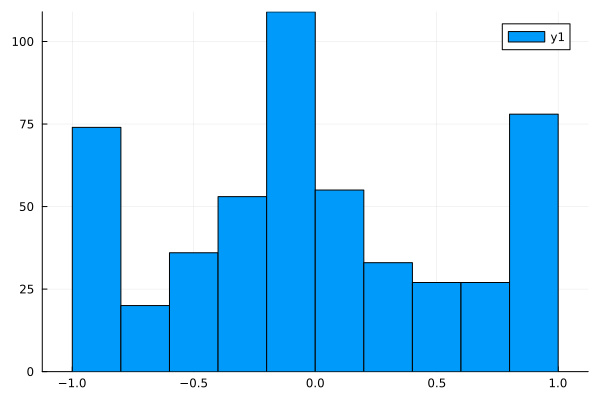

In [122]:
histogram(vec(p0))

In [123]:
stt_phase = st_phase
for (x, _) in train_loader
    _, stt_phase = to_phase(x, ps_phase, stt_phase)
end

In [124]:
ps_phase

(layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = NamedTuple())

In [125]:
stt_phase

(layer_1 = NamedTuple(), layer_2 = NamedTuple())

In [126]:
using ChainRulesCore: ignore_derivatives

In [127]:
function phase_to_current(phases::AbstractArray; spk_args::SpikingArgs)
    function inner(t::Real)
        output = zero(phases)

        ignore_derivatives() do
            times = phases .* spk_args.t_period
            times = mod.(times, spk_args.t_period)

            #add currents into the active synapses
            current_kernel = x -> gaussian_kernel(x, t, spk_args.t_window)
            impulses = current_kernel(times)
            output .+= impulses
        end

        return output
    end

    return inner
end

phase_to_current (generic function with 1 method)

In [128]:
xfn = phase_to_current(x, spk_args=spk_args)

(::var"#inner#64"{SpikingArgs, LinearAlgebra.Adjoint{Float64, Matrix{Float64}}}) (generic function with 1 method)

In [129]:
xfn(0.4)

2×256 Matrix{Float64}:
 0.0367008     0.0          5.11018e-138  …  4.11898e-169  0.0           0.0
 3.19094e-194  8.96151e-11  0.0              0.0           1.56768e-302  0.0

In [130]:
solver_args

Dict{Symbol, Real} with 2 entries:
  :adaptive => false
  :dt       => 0.01

In [131]:
sol_model = Chain(LayerNorm((2,)), 
                    x -> tanh_fast.(x),
                    x -> phase_to_current(x, spk_args=spk_args),
                    PhasorODE(Chain(Dense(2 => 128)), tspan = (0.0, 10.0), dt = solver_args[:dt]))

Chain(
    layer_1 = LayerNorm((2,), affine=true, dims=Colon()),  # 4 parameters
    layer_2 = WrappedFunction{:direct_call}(var"#67#69"()),
    layer_3 = WrappedFunction{:direct_call}(var"#68#70"()),
    layer_4 = PhasorODE(
        model = Dense(2 => 128),        # 384 parameters
    ),
)         # Total: 388 parameters,
          #        plus 0 states.

In [132]:
ps_sol, st_sol = Lux.setup(args.rng, sol_model)

((layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[-0.07523699 0.10901178; -0.06581085 -0.09317045; … ; 0.1776922 -0.13687333; 0.1325277 0.08182763], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;])), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple()))

In [133]:
y_sol, _ = sol_model(x, ps_sol, st_sol)

(ODESolution{ComplexF32, 3, Vector{Matrix{ComplexF32}}, Nothing, Nothing, Vector{Float64}, Vector{Vector{Matrix{ComplexF32}}}, Nothing, ODEProblem{Matrix{ComplexF32}, Tuple{Float64, Float64}, false, @NamedTuple{weight::Matrix{Float32}, bias::Matrix{Float32}}, ODEFunction{false, SciMLBase.AutoSpecialize, Main.PhasorNetworks.var"#dudt#159"{PhasorODE{Dense{true, typeof(identity), typeof(glorot_uniform), typeof(zeros32)}, Tsit5{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}, SciMLSensitivity.InterpolatingAdjoint{0, true, Val{:central}, SciMLSensitivity.ZygoteVJP}, Tuple{Float64, Float64}}, var"#inner#64"{SpikingArgs, Matrix{Float64}}, @NamedTuple{}, Matrix{ComplexF32}}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing, Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, @NamedTuple{}}, SciMLBase.Stand

In [134]:
ode_model = Chain(LayerNorm((2,)), 
                    x -> tanh_fast.(x),
                    x -> phase_to_current(x, spk_args=spk_args),
                    PhasorODE(Chain(Dense(2 => 128)), tspan = (0.0, 10.0), dt = solver_args[:dt]),
                    x -> solution_to_phase(x, spk_args=spk_args)[:,:,end],
                    PhasorDenseF32(128 => 2))

Chain(
    layer_1 = LayerNorm((2,), affine=true, dims=Colon()),  # 4 parameters
    layer_2 = WrappedFunction{:direct_call}(var"#71#74"()),
    layer_3 = WrappedFunction{:direct_call}(var"#72#75"()),
    layer_4 = PhasorODE(
        model = Dense(2 => 128),        # 384 parameters
    ),
    layer_5 = WrappedFunction{:direct_call}(var"#73#76"()),
    layer_6 = PhasorDenseF32((128, 2)),  # 260 parameters
)         # Total: 648 parameters,
          #        plus 0 states.

In [135]:
ps_ode, st_ode = Lux.setup(args.rng, ode_model)

((layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[0.14464144 0.06591951; -0.055113774 -0.14572471; … ; -0.0016148809 0.12866397; 0.14117663 -0.04361241], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;]), layer_5 = NamedTuple(), layer_6 = (weight = Float32[0.20316245 -0.12021117 … 0.24250242 -0.17216624; -0.24742159 -0.06248757 … 0.16843456 -0.013229129], bias_real = Float32[1.0, 1.0], bias_imag = Float32[0.0, 0.0])), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple(), layer_6 = NamedTuple()))

In [136]:
y_ode, _ = ode_model(x, ps_ode, st_ode)

([-0.9966342395792304 0.9829001285633238 … 0.9849432571387539 0.990123934440847; 0.01940826934321517 0.01669390419310535 … 0.014351276887083372 0.004739673828833915], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple(), layer_6 = NamedTuple()))

In [137]:
y_ode

2×256 Matrix{Float64}:
 -0.996634   0.9829     -0.993759  …   0.994398    0.984943   0.990124
  0.0194083  0.0166939  -0.039376     -0.00224136  0.0143513  0.00473967

In [138]:
psf = ComponentArray(ps_ode)

ComponentVector{Float32}(layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = Float32[], layer_3 = Float32[], layer_4 = (weight = Float32[0.14464144 0.06591951; -0.055113774 -0.14572471; … ; -0.0016148809 0.12866397; 0.14117663 -0.04361241], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;]), layer_5 = Float32[], layer_6 = (weight = Float32[0.20316245 -0.12021117 … 0.24250242 -0.17216624; -0.24742159 -0.06248757 … 0.16843456 -0.013229129], bias_real = Float32[1.0, 1.0], bias_imag = Float32[0.0, 0.0]))

In [139]:
mean(quadrature_loss(ode_model(x, psf, st_ode)[1], y))

1.0003561475926854

In [140]:
withgradient(p -> mean(quadrature_loss(ode_model(x, p, st_ode)[1], y)), psf)

(val = 1.0003561481904328, grad = ((layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[0.0; 0.0;;]), layer_2 = Float32[], layer_3 = Float32[], layer_4 = (weight = Float32[-0.001963466 0.0003052987; 5.811736f-5 0.0003444503; … ; 0.00010469484 -0.00080259255; 0.0004860263 0.000302092], bias = Float32[-0.009946791; 0.004874995; … ; -0.009647483; 0.007352103;;]), layer_5 = Float32[], layer_6 = (weight = Float32[-0.00575994 -0.004786343 … -0.005385384 -0.0055776555; -0.016969897 -0.017488392 … -0.01789949 -0.016712403], bias_real = Float32[-0.005178228, -0.01756776], bias_imag = Float32[-0.047691192, 0.005197815])),))

In [141]:
solution_to_phase(y_sol, spk_args=spk_args)

128×256 Matrix{Float64}:
 -0.00122379    0.000113353   0.00199279   …   0.000136272   0.000382539
  0.000911499  -0.00125346   -0.000429819     -0.00112096   -0.000846612
  0.0019632    -0.00278358   -0.0011564       -0.00251735   -0.00192768
  0.00221531    0.000982077  -0.00354697       0.000840768   0.000127165
  0.00191926   -0.00145222   -0.00180739      -0.00132564   -0.00117499
  0.00200433   -0.00289461   -0.00115723   …  -0.00261806   -0.00199833
 -0.00198361    0.00255682    0.00180231       0.00228368    0.00192222
  0.00128154   -0.000611578  -0.0013204       -0.000559896  -0.000567257
  0.00152629   -0.000875147  -0.00153904      -0.000800546  -0.000767685
 -0.0023145     0.000821947   0.00323088       0.000776413   0.00101904
 -0.00204835    0.00187137    0.00226835   …   0.0016871     0.00155043
  0.00149548   -0.00126576   -0.00128405      -0.00114752   -0.000979573
 -0.000941248  -0.000532955   0.00192244      -0.000437408  -4.10292e-5
  ⋮                              

In [142]:
mean(abs.(solution_to_phase(sol_model(x, ps_sol, st_sol)[1], spk_args=spk_args)))

0.0009897774644580472

In [143]:
psf_sol = ComponentArray(ps_sol)

ComponentVector{Float32}(layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = Float32[], layer_3 = Float32[], layer_4 = (weight = Float32[-0.07523699 0.10901178; -0.06581085 -0.09317045; … ; 0.1776922 -0.13687333; 0.1325277 0.08182763], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;]))